See also: [pytorch cartpole DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
# imports
from __future__ import annotations
import gym
import gym_cartpole_swingup
import numpy as np
import torch
import torch.nn
import torch.nn.functional
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm
from dataclasses import dataclass
from itertools import count, chain
import math
from typing import Tuple, List, Dict, Any, Optional, Callable, Union

In [2]:
# config
%matplotlib ipympl

BATCH_SIZE = 120
MEMORY_SIZE = 100000
MEMORY_WARMUP = 5000

LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.995
LEARNING_RATE_UPDATE_INTERVAL = 100 

REWARD_GAMMA = 0.99   

EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 200
EPSILON_SCALE = 5
K = 10

PREVIEW_EPISODE_INTERVAL = 1

POLICY_TARGET_UPDATE_INTERVAL = 10 
SOFT_UPDATE_TAU = 0.01 

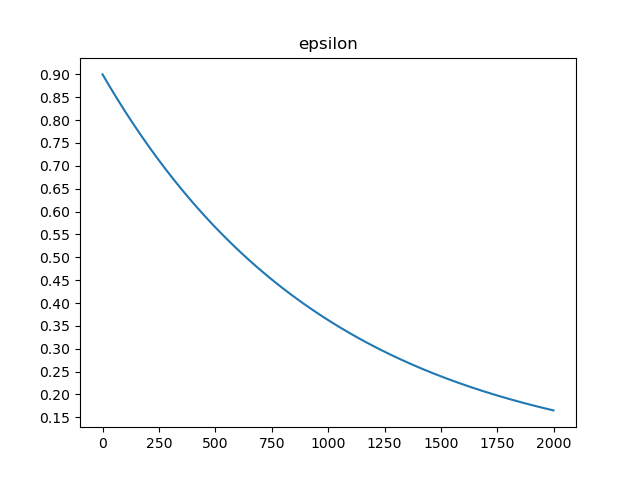

In [3]:
# graph epsilon
plt.figure()
plt.title("epsilon")
plt.yticks(torch.arange(0,1,0.05))
plt.plot([EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * (steps_done/EPSILON_SCALE) / EPSILON_DECAY) for steps_done in range(2000)])
plt.show()

In [4]:
env = gym.make("CartPoleSwingUp-v1")
# env = gym.make("MountainCar-v0")
# env = gym.make("CartPole-v0")

In [5]:
print(env.observation_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (5,), float32)


In [6]:
print(env.reset())

[ 0.02644037 -0.10984278 -0.9364149   0.3508947  -0.11557134]


In [7]:
print(env.action_space)
for _ in range(5):
    print(env.action_space.sample())

Box(-1.0, 1.0, (1,), float32)
[-0.76584786]
[0.8810997]
[0.5648747]
[0.9589935]
[0.93321306]


In [8]:
# preview environment
if False:
    done = False
    env.reset()
    rewards = []
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        env.render()
        rewards.append(reward)
    env.close()
    plt.figure()
    plt.title("rewards")
    plt.plot(rewards)
    plt.show()
    del done, rewards

In [9]:
# action space
# for i in range(500):
#     action_space = torch.linspace(env.action_space.low.item(),env.action_space.high.item(),i).unsqueeze(1)
#     if 0 in action_space:
#         print(i)
action_space = torch.linspace(env.action_space.low.item(),env.action_space.high.item(),305).unsqueeze(1)
assert 0 in action_space # not sure if necessary but it _feels_ right
print(action_space)

tensor([[-1.0000],
        [-0.9934],
        [-0.9868],
        [-0.9803],
        [-0.9737],
        [-0.9671],
        [-0.9605],
        [-0.9539],
        [-0.9474],
        [-0.9408],
        [-0.9342],
        [-0.9276],
        [-0.9211],
        [-0.9145],
        [-0.9079],
        [-0.9013],
        [-0.8947],
        [-0.8882],
        [-0.8816],
        [-0.8750],
        [-0.8684],
        [-0.8618],
        [-0.8553],
        [-0.8487],
        [-0.8421],
        [-0.8355],
        [-0.8289],
        [-0.8224],
        [-0.8158],
        [-0.8092],
        [-0.8026],
        [-0.7961],
        [-0.7895],
        [-0.7829],
        [-0.7763],
        [-0.7697],
        [-0.7632],
        [-0.7566],
        [-0.7500],
        [-0.7434],
        [-0.7368],
        [-0.7303],
        [-0.7237],
        [-0.7171],
        [-0.7105],
        [-0.7039],
        [-0.6974],
        [-0.6908],
        [-0.6842],
        [-0.6776],
        [-0.6711],
        [-0.6645],
        [-0.

In [10]:
# typedefs
State = torch.Tensor
Action = float
Reward = float
StateBatch = torch.Tensor
ActionBatch = torch.Tensor
RewardBatch = torch.Tensor
TerminalBatch = torch.Tensor

In [11]:
class Actor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(5,32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.fc2 = torch.nn.Linear(32,32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(32,32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.out = torch.nn.Linear(32, 1)

    def forward(self, x: StateBatch) -> ActionBatch:
        x = torch.nn.functional.gelu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.gelu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.gelu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x

In [12]:
actor = Actor()
actor_target = Actor()
actor_target.eval()
print(actor_target(torch.as_tensor(env.reset()).unsqueeze(0)))

tensor([[-0.1787]], grad_fn=<AddmmBackward0>)


In [13]:
class Critic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(6,32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.fc2 = torch.nn.Linear(32,32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(32,32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.out = torch.nn.Linear(32, 1)

    def forward(self, x_: Tuple[StateBatch, ActionBatch]) -> ActionBatch:
        x = torch.hstack(x_)
        x = torch.nn.functional.gelu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.gelu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.gelu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x

In [14]:
critic = Critic()
critic_target = Critic()
critic_target.eval()

state_batch = torch.as_tensor(env.reset()).unsqueeze(0)
proto_action = actor_target(state_batch)
k_dist = torch.cdist(proto_action, action_space)
nearest = torch.topk(k_dist, K, dim=1, largest=False).indices
actions = action_space[nearest].squeeze(0)
q_values = critic_target((state_batch.repeat(K,1), actions))
best = actions[q_values.argmax()]
print("proto actions\t", proto_action)
print("action space\t", action_space)
print("k distances\t", k_dist)
print("best\t", nearest)
print("nearest actions\t", actions)
print("q values\t", q_values)
print("best\t", best)
del state_batch, proto_action, k_dist, nearest, actions, q_values, best

proto actions	 tensor([[-0.1761]], grad_fn=<AddmmBackward0>)
action space	 tensor([[-1.0000],
        [-0.9934],
        [-0.9868],
        [-0.9803],
        [-0.9737],
        [-0.9671],
        [-0.9605],
        [-0.9539],
        [-0.9474],
        [-0.9408],
        [-0.9342],
        [-0.9276],
        [-0.9211],
        [-0.9145],
        [-0.9079],
        [-0.9013],
        [-0.8947],
        [-0.8882],
        [-0.8816],
        [-0.8750],
        [-0.8684],
        [-0.8618],
        [-0.8553],
        [-0.8487],
        [-0.8421],
        [-0.8355],
        [-0.8289],
        [-0.8224],
        [-0.8158],
        [-0.8092],
        [-0.8026],
        [-0.7961],
        [-0.7895],
        [-0.7829],
        [-0.7763],
        [-0.7697],
        [-0.7632],
        [-0.7566],
        [-0.7500],
        [-0.7434],
        [-0.7368],
        [-0.7303],
        [-0.7237],
        [-0.7171],
        [-0.7105],
        [-0.7039],
        [-0.6974],
        [-0.6908],
        [-0.6

In [15]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
    # using .parameters() doesn't include all params for batchnorm causing issues
    for (k1, v1), (k2, v2) in zip(target.state_dict().items(), source.state_dict().items()):
        assert k1 == k2
        v1.copy_(v1 * (1.0 - tau) + v2 * tau)
        # target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    target.load_state_dict(source.state_dict())
    # for target_param, param in zip(target.parameters(), source.parameters()):
    #         target_param.data.copy_(param.data)

In [16]:
hard_update(actor_target, actor)
hard_update(critic_target, critic)

In [17]:
# transitions
@dataclass
class Transition:
    state: State
    action: Action
    reward: Reward
    next_state: State
    terminal: bool

@dataclass
class TransitionBatch:
    states: StateBatch
    actions: ActionBatch
    rewards: RewardBatch
    next_states: StateBatch
    terminals: TerminalBatch

In [18]:
memory = deque(maxlen=MEMORY_SIZE)

In [19]:
# manual play

if False:
    import gym.utils.play
    import pygame
    # mapping = {pygame.K_LEFT: np.array([-1]), pygame.K_RIGHT: np.array([1])}
    # mapping = {"a": np.   array([-1]), "d": np.array([1])}
    mapping = {(ord("a"),): -1.0, (ord("d"),): 1.0}
    print(mapping)
    with tqdm() as pbar:
        def callback(
            obs_t: np.ndarray,# observation before performing action
            obs_tp1: np.ndarray,# observation after performing action
            action: float,# action that was executed
            rew: float,# reward that was received
            terminated: bool,# whether the environment is terminated or not
            info,# debug info
        ):
            memory.append(Transition(
                state=torch.as_tensor(obs_t),
                action=action,
                reward=rew,
                next_state=torch.as_tensor(obs_tp1),
                terminal=terminated,
            ))
            pbar.set_description(f"reward: {rew:.2f}, action: {action:.2f}, memory: {len(memory)}")
            pbar.update()
        gym.utils.play.play(env, keys_to_action=mapping, callback=callback)

In [20]:
# pygame.quit()

In [21]:
def sample_memory(batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.as_tensor([s.action for s in samples], dtype=torch.float32),
        rewards=torch.as_tensor([s.reward for s in samples], dtype=torch.float32),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.as_tensor([s.terminal for s in samples], dtype=torch.bool),
    )

In [22]:
def get_action(state: State, epsilon: float) -> Action:
    # epsilon-greedy exploration
    if random.random() < epsilon:
        return env.action_space.sample().item()

    # convert single state to batch
    state_batch = state.unsqueeze(0)

    # ensure models are set to eval mode
    actor.eval()
    critic.eval()

    # get proto actions

    with torch.no_grad():
        proto_actions = actor(state_batch)

    # get nearest neighbours to proto actions
    distances = torch.cdist(proto_actions, action_space)
    best = torch.topk(distances, K, dim=1, largest=False).indices
    actions = action_space[best].squeeze(0)

    # copy state batch to match action batch
    state_batch = state_batch.repeat(K,1)

    # get q values for actions
    with torch.no_grad():
        q_values = critic((state_batch, actions))

    # get best action
    best = actions[q_values.argmax()]
        
    return best.item()

print(get_action(torch.as_tensor(env.reset()), 0))

0.09868419170379639


In [23]:
actor_loss_history = []
critic_loss_history = []
actor_learning_rate_history = []
critic_learning_rate_history = []
reward_history = []
duration_history = []
action_history = []
terminal_history = []

In [24]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [25]:
# actor_optimizer = torch.optim.RMSprop(actor.parameters(), lr=LEARNING_RATE)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)
actor_scheduler = torch.optim.lr_scheduler.StepLR(
    actor_optimizer,
    step_size=LEARNING_RATE_UPDATE_INTERVAL,
    gamma=LEARNING_RATE_GAMMA,
)
# critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE)
critic_scheduler = torch.optim.lr_scheduler.StepLR(
    critic_optimizer,
    step_size=LEARNING_RATE_UPDATE_INTERVAL,
    gamma=LEARNING_RATE_GAMMA,
)
# criterion = torch.nn.SmoothL1Loss()
criterion = torch.nn.MSELoss()
steps_done = 0

In [26]:
# train loop
# %%scalene
warmup_steps = max(MEMORY_WARMUP, BATCH_SIZE)
with tqdm() as pbar:
    for episode in count():
        state = torch.as_tensor(env.reset(), dtype=torch.float32)

        for i in count():
            #region exploration
            epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * ((steps_done-warmup_steps)/EPSILON_SCALE) / EPSILON_DECAY)
            steps_done += 1
            action = get_action(state, epsilon)
            action_history.append(action)
            next_state, reward, done, info = env.step(action)
            reward_history.append(reward)
            terminal_history.append(done)
            if done:
                duration_history.append(i)
                next_state = torch.zeros(state.shape)
            else:
                next_state = torch.as_tensor(next_state, dtype=torch.float32)                
            memory.append(Transition(
                state=state,
                action=action,
                reward=reward,
                next_state=next_state,
                terminal=done,
            ))
            state = next_state
            if episode % PREVIEW_EPISODE_INTERVAL == 0:
                env.render()
            #endregion exploration

            #region training
            if len(memory) < warmup_steps:
                pbar.set_description(f"warmup")
            else:
                actor.train()
                critic.train()

                batch = sample_memory(BATCH_SIZE)

                # calculate discounted future reward
                q_next = critic_target((batch.next_states, actor_target(batch.next_states)))
                q_targ = batch.rewards.unsqueeze(1) + (~batch.terminals.unsqueeze(1) * REWARD_GAMMA * q_next)

                # critic gradient
                critic_optimizer.zero_grad()
                q_pred = critic((batch.states, batch.actions.unsqueeze(1)))
                critic_loss = criterion(q_pred, q_targ) 
                critic_loss.backward()

                # actor gradient
                actor_optimizer.zero_grad()
                actor_loss = -critic((batch.states, actor(batch.states))).mean()
                actor_loss.backward()


                # clamp gradients
                for param in chain(actor.parameters(), critic.parameters()):
                    param.grad.data.clamp_(-1, 1)

                # apply weight updates
                critic_optimizer.step()
                actor_optimizer.step()

                # update target networks
                soft_update(critic_target, critic, SOFT_UPDATE_TAU)
                soft_update(actor_target, actor, SOFT_UPDATE_TAU)
                # if i % POLICY_TARGET_UPDATE_INTERVAL == 0:
                #     hard_update(critic_target, critic)
                #     hard_update(actor_target, actor)

                # track stats
                critic_loss_history.append(critic_loss.item())
                critic_learning_rate_history.append(critic_scheduler.get_last_lr()[0])
                actor_loss_history.append(actor_loss.item())
                actor_learning_rate_history.append(actor_scheduler.get_last_lr()[0])

                # update learning rates
                critic_scheduler.step()
                actor_scheduler.step()

                # update progress bar
                pbar.set_description(f"action: {action:+03.2f}, reward: {reward:+03.2f}, critic: {critic_loss.item():09.3f}, actor: {actor_loss.item():09.3f}, epsilon: {epsilon:.3f}, lr: {actor_scheduler.get_last_lr()[0]:.4f}, steps: {steps_done}, memory: {len(memory)} ")
            #endregion training

            # skip to next episode if done
            if done: break

        pbar.update()
env.close()

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
# make cell output monospaced
from IPython.core.display import HTML
HTML(r"""
<style>
    .output-plaintext, .output-stream, .output {
        font-family: consolas; # Any monospaced font should work
        line-height: 1.3 !important;
        font-size: 14px !important;
    }
</style>
""")

In [ ]:
# episode durations
plt.figure()
plt.plot(duration_history)
plt.title("Episode durations")
plt.show()

In [ ]:
# episode durations
plt.figure()
plt.plot(reward_history)
plt.title("rewards")
plt.show()

In [ ]:
# episode durations
plt.figure()
plt.plot(critic_loss_history[-300:])
plt.title("Loss")
plt.show()

In [ ]:
# investigate actions
import ipywidgets as widgets
plt.figure()
@widgets.interact(i=(0, len(action_history)-1), window_size=(1, len(action_history)-1))
def preview_actions(i=len(action_history)-100, window_size=100):
#     x = torch.zeros((len(action_history), env.action_space.n + 1))
#     x[range(len(action_history)), action_history] = 1
#     x[:, 2] = torch.as_tensor(terminal_history, dtype=torch.bool)
    plt.cla()
    plt.plot(action_history[i:i+window_size])
    plt.show()

In [ ]:
# preview
for _ in range(5):
    state = env.reset()
    done = False
    while not done:
        action = get_action(torch.as_tensor(state), 0)
        next_state, reward, done, info = env.step(action)
        env.render()
        frame = env.render()
        state = next_state

env.close()

In [ ]:
env.close()
pygame.quit()